# Segmentation

In [1]:
!pip install pymaxflow

In [2]:

import maxflow as mx
from PIL import Image
from cv2 import imshow
from numpy import asarray, mgrid, uint8
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.color import hsv2rgb
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import KernelDensity
import numpy as np
import guiseg
import cv2

# variables to play with



In [3]:
# Implementation Here (feel free to add additional cells of course)
def segmentation(image, fore, back, sigma_1, sigma_2, lambd):

    # Create the graph.
    graph = mx.Graph[float]()
    nodeids = graph.add_grid_nodes(image.shape[:2])
    # print(image.shape[:2])

    # Make distributions for fore and back seeds
    kde_fore = KernelDensity(kernel='gaussian', bandwidth=sigma_1).fit(image[fore])
    kde_back = KernelDensity(kernel='gaussian', bandwidth=sigma_1).fit(image[back])
    # print(image[fore].shape)

    # Compare each pixel rto distributions with R(p) equations for link Ts
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            fore_prob = kde_fore.score(image[i][j].reshape(-1, 3) )
            back_prob = kde_back.score(image[i][j].reshape(-1, 3) )
            graph.add_tedge(nodeids[i][j],fore_prob,back_prob)
            
    print(fore_prob)
    print(back_prob)

    # Run B(p) on each link N. set as value
    def B_pq(curr_pixel,neig_pixel):
        if not isinstance(curr_pixel, np.ndarray) or not isinstance(neig_pixel, np.ndarray):
            raise ValueError("Both parameters must be NumPy arrays")
        diff_val = (curr_pixel - neig_pixel)
        magnitude = np.linalg.norm(diff_val)

        exponent = -(magnitude**2)/(2*(sigma_2**2))

        result = lambd * np.exp(exponent)
        return result

    # print(image.shape[0])
    # print(image.shape[1])
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
        
            #bottom right corner of image
            if j == image.shape[1]-1 and i == image.shape[0]-1:
                pass         
            
            #edges of image
            elif i == image.shape[0]-1:
                right_cost = B_pq(image[i][j],image[i][j+1])
                graph.add_edge(nodeids[i][j], nodeids[i][j+1],right_cost ,right_cost)

            elif j == image.shape[1]-1:
                down_cost = B_pq(image[i][j],image[i+1][j])
                graph.add_edge(nodeids[i][j], nodeids[i+1][j],down_cost ,down_cost)

            #all interior pixels
            else:
                right_cost = B_pq(image[i][j],image[i][j+1])
                down_cost = B_pq(image[i][j],image[i+1][j])

                graph.add_edge(nodeids[i][j], nodeids[i][j+1], right_cost,right_cost)
                graph.add_edge(nodeids[i][j], nodeids[i+1][j], down_cost,down_cost)      

    # Use maxflow to cut
    graph.maxflow()
    sgm = graph.get_grid_segments(nodeids)

    sgm_seg = sgm.astype(np.uint8)
    dil_kernel = np.ones((5,5),uint8)


    sgm_dilate = cv2.dilate(sgm_seg,kernel=dil_kernel)
    sgm_erosion = cv2.erode(sgm_dilate,kernel=dil_kernel,iterations=2)
    image_final = np.int_(np.logical_not(sgm_erosion))

    return image_final, fore, back


def plot_all(image_og, image_seg, truth_image, fore, back):
    
    #create the tri image
    scalar = 10
    tri = np.zeros(image_og.shape[:2]) + .5
    tri[fore] = 1
    tri[back] = 0

    inverted_image = cv2.bitwise_not(image_seg)  
    seg = np.zeros(image_og.shape[:2]) + inverted_image

    tri_image = cv2.merge([image_og,(tri*255).astype(np.uint8)])

    
    image_seg_ol = cv2.merge([image_og,(seg*100).astype(np.uint8)])

    fig, axes = plt.subplots(1,4)

    axes[0].imshow(image_og)
    axes[0].set_title('Original Image')

    axes[1].imshow(tri_image)
    axes[1].set_title('Tri Image')

    axes[2].imshow(image_seg_ol)
    axes[2].set_title('Segmented Image')

    axes[3].imshow(truth_image)
    axes[3].set_title('Truth Image')

    plt.show()

[[171 122   4]
 [142  92   0]
 [175 124   7]
 [185 135  14]
 [185 136  15]]
[[197 130  25]
 [199 132  27]
 [201 134  30]
 [201 134  30]
 [201 133  32]]
-13.759312876721225
-18.631050486990087


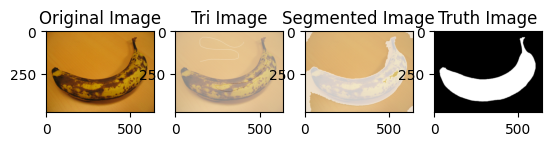

In [4]:
# Banana

imageBGR = cv2.imread('provided_images/banana.png');
image = imageBGR[:,:,::-1]; 

truth_image = cv2.imread('provided_images/ground_truth/banana_seg.png');


fore, back = guiseg.get_fore_back(image)
print(image[fore][:5])  
print(image[back][:5])  

banana_seg = segmentation(image, fore, back,15,100,25)   
plot_all(image,banana_seg[0],truth_image, banana_seg[1],banana_seg[2])

In [5]:
# Llama

imageBGR = cv2.imread('provided_images/llama.jpg');
image = imageBGR[:,:,::-1]; 

truth_image = cv2.imread('provided_images/ground_truth/llama_seg.png');


fore, back = guiseg.get_fore_back(image)
print(image[fore][:5])  
print(image[back][:5])  

banana_seg = segmentation(image, fore, back,15,100,25)   
plot_all(image,banana_seg[0],truth_image, banana_seg[1],banana_seg[2])

[]
[]


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by KernelDensity.

[[157  90  82]
 [148  78  70]
 [144  74  66]
 [159  89  79]
 [160  94  82]]
[[237 255 255]
 [236 254 254]
 [235 253 253]
 [235 253 253]
 [237 255 255]]
-13.123076492665584
-13.459404463309113


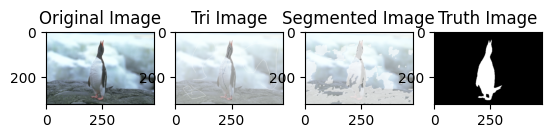

In [ ]:
# Penguin

imageBGR = cv2.imread('provided_images/penguin.png');
image = imageBGR[:,:,::-1]; 

truth_image = cv2.imread('provided_images/ground_truth/penguin_seg.png');


fore, back = guiseg.get_fore_back(image)
print(image[fore][:5])  
print(image[back][:5])  

banana_seg = segmentation(image, fore, back,15,100,25)   
plot_all(image,banana_seg[0],truth_image, banana_seg[1],banana_seg[2])

[[181 156 102]
 [190 168 118]
 [191 171 121]
 [204 183 136]
 [178 160 114]]
[[129  17   6]
 [134  22  10]
 [133  21   9]
 [130  18   7]
 [131  19   8]]
-33.390095769329726
-11.403312689211738


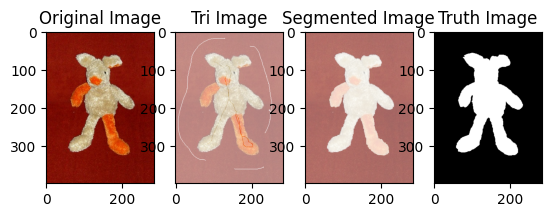

In [ ]:
# Teddy

imageBGR = cv2.imread('provided_images/teddy.png');
image = imageBGR[:,:,::-1]; 

truth_image = cv2.imread('provided_images/ground_truth/teddy_seg.png');


fore, back = guiseg.get_fore_back(image)
print(image[fore][:5])  
print(image[back][:5])  

banana_seg = segmentation(image, fore, back,15,100,25)   
plot_all(image,banana_seg[0],truth_image, banana_seg[1],banana_seg[2])

[[34 38 49]
 [34 38 49]
 [33 37 48]
 [33 37 48]
 [32 36 47]]
[[253 253 253]
 [253 253 253]
 [253 253 253]
 [253 253 253]
 [253 253 253]]
-15.158380275909447
-12.226887825440686


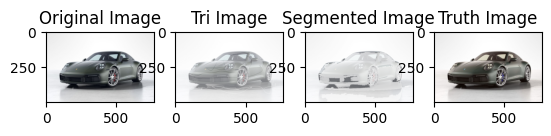

In [ ]:
# Porche: Easy because of very different colors

imageBGR = cv2.imread('user_data/daPorche.png');
image = imageBGR[:,:,::-1]; 

truth_image = cv2.imread('user_data/daPorche.png');


fore, back = guiseg.get_fore_back(image)
print(image[fore][:5])
print(image[back][:5])

banana_seg = segmentation(image, fore, back,15,100,25)   
plot_all(image,banana_seg[0],truth_image, banana_seg[1],banana_seg[2])

[[ 79  43  27]
 [109  71  58]
 [ 48  31  15]
 [ 68  39  33]
 [ 89  61  39]]
[[139 105  59]
 [146 112  64]
 [165 112  70]
 [146 105  61]
 [165 129  77]]
-13.327696863668448
-12.492811254694608


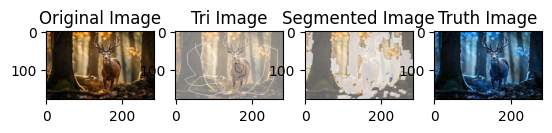

In [ ]:
# Deer: hard because the backround is a similar color to the subject

imageBGR = cv2.imread('user_data/Deer.png');
image = imageBGR[:,:,::-1]; 

truth_image = cv2.imread('user_data/Deer.png');


fore, back = guiseg.get_fore_back(image)
print(image[fore][:5])  
print(image[back][:5])  

banana_seg = segmentation(image, fore, back,15,100,25)   
plot_all(image,banana_seg[0],truth_image, banana_seg[1],banana_seg[2])

<span style="color:white;">I used a function that compared the loglikleyhood that the pixels were in the fore or back to find the t-links and a neighbor function found in the lecture slides to make a neighboring pixel function.  I then gave the t-links and N-links values based on that.  the graph cut segmentation seems to work well when there is a color differential.  When there are similar colors in the foreground and the backround it is a lot harder to get a usable result.  I learned alot about image manipulation, and I enjoyed working with pymaxflow.  I didn't feel like some things were super clear.  Specifically the t-link and n-link functions.  I was looking for a library that would do it for me if I had the right inputs (as we have done in other labs)  but ended up just having to do it pixel by pixel.</span>